In [1]:
import numpy as np
from sklearn import manifold
from dreimac import GeometryUtils, CircleMapUtils, CircularCoords
from ripser import ripser
from persim import plot_diagrams
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix, dok_array
from plotly.subplots import make_subplots
from scipy.sparse.csgraph import shortest_path


In [3]:
np.random.seed(2)
n_data = 2500
R = 5
r = 2
data = np.zeros((n_data, 3))
s = np.random.rand(n_data)*2*np.pi
t = np.random.rand(n_data)*2*np.pi

data[:, 0] = (R + r*np.cos(s))*np.cos(t)
data[:, 1] = (R + r*np.cos(s))*np.sin(t)
data[:, 2] = r*np.sin(s)
data += 0.1*np.random.randn(*data.shape)

# Plot the data 
fig = go.Figure(data=[go.Scatter3d(
    x=data[:,0], y=data[:,1], z=data[:,2], 
    mode ='markers', 
    marker=dict(size = 1.5 , color = 'grey'))])

fig.update_layout( showlegend=False )
fig.show(renderer='iframe')

In [4]:
#penta2 = np.loadtxt('data/genus_3_clean.txt', delimiter=',')
print(data.shape)

(2500, 3)


In [ ]:
#energy computation

# angle_data = np.zeros((penta2.shape[0],5)) # internal angles

# for i in range(5):
#     ii = (2*i -2)%10
#     jj = (2*i - 1)%10
#     u = penta2[:, [ii, jj]]
    
#     ii = (2*i)%10
#     jj = (2*i + 1)%10
#     v = penta2[:, [ii , jj]]
    
#     ii = (2*i + 2)%10
#     jj = (2*i + 3)%10
#     w = penta2[:, [ii, jj]]
    
#     z = np.sum((u - v)*(w-v), axis = 1)
    
#     angle_data[:,i]  = np.arccos( np.minimum(z,1) )
    
# energy = np.sum((angle_data - (3/5)*np.pi)**2 , axis = 1)

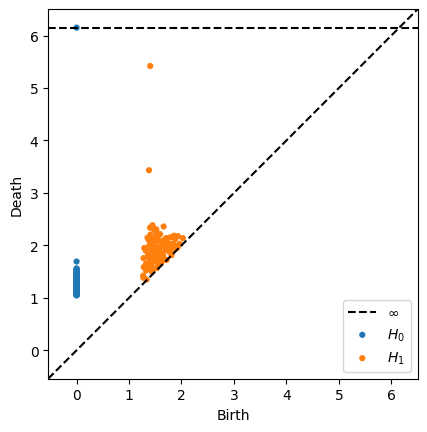

In [5]:
n_lands = 200

cc = CircularCoords(data, n_landmarks=n_lands)

plot_diagrams(cc.dgms_)

In [9]:
coho_classes = [0, 1]

circular_coords = []

for i in coho_classes:
    theta = cc.get_coordinates(perc= 0, cocycle_idx=i)
    theta = CircleMapUtils.center(theta)
    #theta = CircleMapUtils.to_sinebow(np.pi + CircleMapUtils.center(theta))
    circular_coords.append(theta)

In [10]:
fig = make_subplots(rows=1, cols=len(coho_classes), 
                    subplot_titles = tuple('Circ Coord '+str(i+1) for i in coho_classes),
                    specs = [[{'type': 'scatter3d'} for i in coho_classes]])

for i, coord in enumerate(circular_coords):
    fig.add_trace(
        go.Scatter3d(x=data.T[0], y=data.T[1], z=data.T[2],   mode ='markers', 
        marker=dict(size = 2 , color =  circular_coords[i])),  
        row=1, col=i+1)
    fig.update_scenes(xaxis=dict( ticks='', showticklabels=False), 
                      yaxis=dict( ticks='', showticklabels=False), 
                      zaxis=dict( ticks='', showticklabels=False), 
                      aspectmode='data', row=1, col=i+1)

fig.update_layout( showlegend=False )
fig.show(renderer='iframe')

In [11]:
circular_coords[0]

array([5.08336746, 0.17572023, 3.64145574, ..., 1.49670142, 4.61160472,
       3.16629464])

In [ ]:
#implementing circular coords to find cuts found via persistent cohomology genus 3 jupyter notebook

# n_lands = 900

# cc = CircularCoords(dist_mat, n_landmarks= n_lands, distance_matrix = True)

# coho_classes = [0, 1, 2, 3, 4, 5]

# circular_coords = []

# for i in coho_classes:
#     circular_coords.append(cc.get_coordinates(perc = 0.6, cocycle_idx=i, standard_range= False))

# #Applying Circular coords and doing TDR

# thetas= CircleMapUtils.linear_combination(np.array(circular_coords), [[1,0,0,0,0,0], [0,1,0,0,0,0],[0,0,1,0,0,0], [0,0,0,1,0,0], [0,0,0,0,1,0],[0,0,0,0,0,1]])
# #Standard Basis, 1,2,6 little fold for genus 3

# theta1 = CircleMapUtils.center(thetas[0])
# theta2 = CircleMapUtils.center(thetas[1])
# theta3 = CircleMapUtils.center(thetas[2])
# theta4 = CircleMapUtils.center(thetas[3])
# theta5 = CircleMapUtils.center(thetas[4])
# theta6 = CircleMapUtils.center(thetas[5])

# fig = go.Figure(data=[go.Scatter3d(
#     x=theta1, y=theta2, z=theta3, 
#     mode ='markers', 
#     marker=dict(size = 3, color =energy[pointcloud_permutation], colorscale='plasma')
# )])

# fig.update_layout(autosize=False, width=700, height=700)

# fig.show()




In [ ]:
theta1

In [ ]:
# n_lands=1000

# coho_data = np.array([theta1, theta2, theta6])

# coho = CircularCoords(coho_data.T , n_landmarks= n_lands)

# coho_classes = [0, 1, 2, 3, 4, 5]

# circular_coords_coho = []

# for i in coho_classes:
#     circular_coords_coho.append(coho.get_coordinates(perc = 0.6, cocycle_idx=i, standard_range= False))
    
# thetas_prime = CircleMapUtils.linear_combination(circular_coords_coho,[[1,0,0,0,0,0], [0,1,0,0,0,3],[1,0,1,0,0,0],[1,0,0,1,0,0],[0,0,0,0,2,1],[0,0,0,0,0,1]])

# fig = make_subplots(rows=1, cols=len(coho_classes), 
#                     subplot_titles = tuple('Circ Coord '+str(i) for i in coho_classes),
#                     specs = [[{'type': 'scatter3d'} for i in coho_classes]])

# for i, coord in enumerate(circular_coords_coho):
#     fig.add_trace(
#         go.Scatter3d(x=theta1, y=theta2, z=theta6,   mode ='markers', 
#         marker=dict(size = 2 , color = (thetas_prime[i]))),  
#         row=1, col=i+1)
#     fig.update_scenes(xaxis=dict( ticks='', showticklabels=False), 
#                       yaxis=dict( ticks='', showticklabels=False), 
#                       zaxis=dict( ticks='', showticklabels=False), 
#                       aspectmode='data', row=1, col=i+1)

# fig.update_layout( showlegend=False )
# fig.show()

6.2806252369563484


(array([43., 36., 23., 24., 35., 38., 40., 40., 31., 24., 29., 28., 20.,
        34., 41., 36., 35., 31., 43., 45., 30., 30., 39., 43., 39., 26.,
        23., 35., 23., 42., 24., 27., 33., 21., 27., 32., 31., 19., 20.,
        40., 58., 38., 30., 19., 22., 40., 26., 45., 53., 32., 37., 44.,
        27., 43., 49., 29., 24., 18., 28., 22., 18., 47., 37., 31., 26.,
        20., 26., 24., 15., 28., 19., 34., 26., 35., 33., 22., 31., 21.,
        27., 16.]),
 array([1.09273646e-03, 7.95868927e-02, 1.58081049e-01, 2.36575205e-01,
        3.15069361e-01, 3.93563518e-01, 4.72057674e-01, 5.50551830e-01,
        6.29045987e-01, 7.07540143e-01, 7.86034299e-01, 8.64528455e-01,
        9.43022612e-01, 1.02151677e+00, 1.10001092e+00, 1.17850508e+00,
        1.25699924e+00, 1.33549339e+00, 1.41398755e+00, 1.49248171e+00,
        1.57097586e+00, 1.64947002e+00, 1.72796417e+00, 1.80645833e+00,
        1.88495249e+00, 1.96344664e+00, 2.04194080e+00, 2.12043496e+00,
        2.19892911e+00, 2.27742327e+00

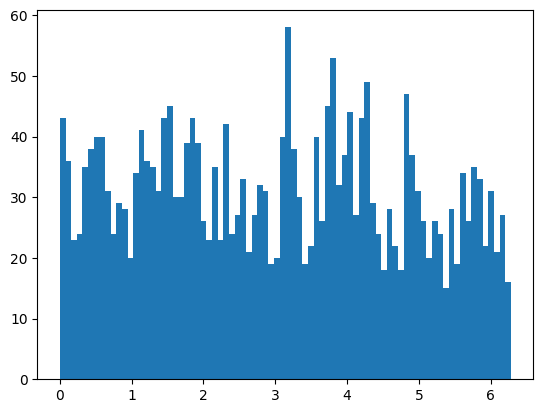

In [16]:
print(max(circular_coords[0]))
plt.hist(circular_coords[0],bins=80)

In [23]:
#take in cuts as a circular coordinate array called cut1,...
cut1=circular_coords[0]
cut2=circular_coords[1]
epsilon=0.4
removed_points=[num for num, x in enumerate(cut1) if x<epsilon or x > (2*np.pi-epsilon)]
rempoin=[num for num, x in enumerate(cut2) if x<epsilon or x > (2*np.pi-epsilon)]

n_land = 900
k_neigh = 20
nbrs = NearestNeighbors(n_neighbors=k_neigh, algorithm='ball_tree').fit(data)
distances, indices = nbrs.kneighbors(data)
# spatial_tree = KDTree(data)
# distances_nn, indices_nn = spatial_tree.query(data, k=k_neigh)
# n_queries = data.shape[0]
# n_nonzero = n_queries * k_neigh
# indptr = np.arange(0, n_nonzero + 1, k_neigh)
# kneighbors_graph = csr_matrix(
#             (distances_nn.ravel(), indices_nn.ravel(), indptr),
#             shape=(n_queries, n_queries),
# ).tolil()


combined_graph=[[indices[i],distances[i]] for i in range(len(indices))]


In [24]:
print(len(removed_points))

278


In [25]:
#takes points to remove and sets them to zero and then removes all zeros

for i in removed_points:
    for j in combined_graph[i][0]:
        if j in removed_points:
            index=np.where(combined_graph[i][0]==j)[0][0]
            combined_graph[i][0]=np.delete(combined_graph[i][0],index)
            combined_graph[i][1]=np.delete(combined_graph[i][1],index)
            
print(len(combined_graph))

2500


In [26]:
print(combined_graph[0])

[array([   0,  457, 2277, 1736,  629, 1499, 1421, 2421,  702, 1539,  252,
       1598,  597,  858,  652, 1626, 2440, 2466, 1399, 2169]), array([0.        , 0.21091664, 0.26658136, 0.36048538, 0.38828411,
       0.42579166, 0.42950006, 0.52588407, 0.56783242, 0.57416196,
       0.63535714, 0.69946477, 0.71330192, 0.71620839, 0.77356021,
       0.78934159, 0.82924374, 0.83870152, 0.86235832, 0.86242624])]


In [35]:
kneighbors_graph=np.zeros((n_data,n_data))
for count, info in enumerate(combined_graph):
    for place, ind in enumerate(info[0]):
        kneighbors_graph[count,ind]=info[1][place]


In [36]:
#calculating geodesic distance matrix
n_landmarks=800

n_points = data.shape[0]
perm = np.zeros(n_landmarks, dtype=np.int64)
lambdas = np.zeros(n_landmarks)
ds = shortest_path(kneighbors_graph, indices=0, directed=False)
D = np.zeros((n_landmarks, n_points))
D[0, :] = ds
for i in range(1, n_landmarks):
    idx = np.argmax(ds)
    perm[i] = idx
    lambdas[i] = ds[idx]
    thisds = shortest_path(kneighbors_graph, indices=idx, directed=False)
    D[i, :] = thisds
    ds = np.minimum(ds, thisds)

perm_rest_points = np.setdiff1d(
np.arange(0, n_points, dtype=int), perm, assume_unique=True
)
perm_all_points = np.concatenate((perm, perm_rest_points))

dist_landmarks_points = D[:, perm_all_points]

KeyboardInterrupt: 

In [ ]:
print(dist_landmarks_points)

In [ ]:
mds= manifold.MDS(
    n_components=2,
    metric=True,
    dissimilarity="precomputed",
)
unfolding = mds.fit(dist_landmarks_points)

In [ ]:
plt.scatter(unfolding[:,0], unfolding[:,1])